<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/01_pytorch_workflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Table of contents**<a id='toc0_'></a>    
- [PyTorch Workflow](#toc1_)    
  - [Check the software and OS version](#toc1_1_)    
  - [Data (preparing and loading)](#toc1_2_)    
    - [Splitting data into training and test sets (one of the most important concepts in machine learning in general)](#toc1_2_1_)    
  - [Build model](#toc1_3_)    
    - [PyTorch model building essentials](#toc1_3_1_)    
    - [Checking the contents of our PyTorch model](#toc1_3_2_)    
    - [Making prediction using `torch.inference_mode()`](#toc1_3_3_)    
  - [Train model](#toc1_4_)    
    - [Building a training loop (and a testing loop) in PyTorch](#toc1_4_1_)    
  - [Saving a model in PyTorch](#toc1_5_)    
  - [Loading a PyTorch model](#toc1_6_)    
  - [Putting it all together](#toc1_7_)    
    - [Data](#toc1_7_1_)    
    - [Building a PyTorch Linear model](#toc1_7_2_)    
    - [Training](#toc1_7_3_)    
    - [Making and evaluating predictions](#toc1_7_4_)    
    - [Saving & loading a trained model](#toc1_7_5_)    
  - [Exercises & Extra-curriculum](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[PyTorch Workflow](#toc0_)

Let's explore a an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions

## <a id='toc1_1_'></a>[Check the software and OS version](#toc0_)

In [129]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-01 15:30:24.648144


In [130]:
# Check to see if we're using a GPU
!nvidia-smi

Thu Jun  1 15:30:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060       WDDM | 00000000:01:00.0  On |                  N/A |
| 33%   36C    P8               23W / 184W|   1749MiB / 12288MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

```
Tue May 30 11:05:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060       WDDM | 00000000:01:00.0  On |                  N/A |
| 32%   38C    P8               22W / 184W|    782MiB / 12288MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
```

In [131]:
# Check your software and os version
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

import torch
print("Pytorch version is",torch.__version__)

print("Are we using a GPU?",torch.cuda.is_available())

posix = Linux, nt = windows, java = java
your os name is nt
your os is  Windows10
python version is 3.9.16
Pytorch version is 2.0.1+cu118
Are we using a GPU? True


In [132]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluting a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [133]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks 
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## Deep-Learning-API

In [214]:
# for linux command
# if os.path.exists("helper_functions.py") != True:
#     !wget https://github.com/chioujryu/Deep-Learning-API/raw/main/helper_functions.py

# for windows command
import wget
if os.path.exists("helper_functions.py") != True:
    wget.download('https://github.com/chioujryu/Deep-Learning-API/raw/main/helper_functions.py')

In [215]:
from helper_functions import list_directory_tree_structure

ModuleNotFoundError: No module named 'tensorflow'

## <a id='toc1_2_'></a>[Data (preparing and loading)](#toc0_)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA 
* Text

Machine learning is a game of two parts: 
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**. 

In [134]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

print("X look like = \n", X[:10], type(X), "\n" , "y look like = \n", y[:10], type(y))

X look like = 
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) <class 'torch.Tensor'> 
 y look like = 
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]]) <class 'torch.Tensor'>


In [135]:
len(X), len(y)

(50, 50)

### <a id='toc1_2_1_'></a>[Splitting data into training and test sets (one of the most important concepts in machine learning in general)](#toc0_)

Let's create a training and test set with our data.

In [136]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

# You also can use train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [137]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop={"size": 14});

  # you can check the usage from here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

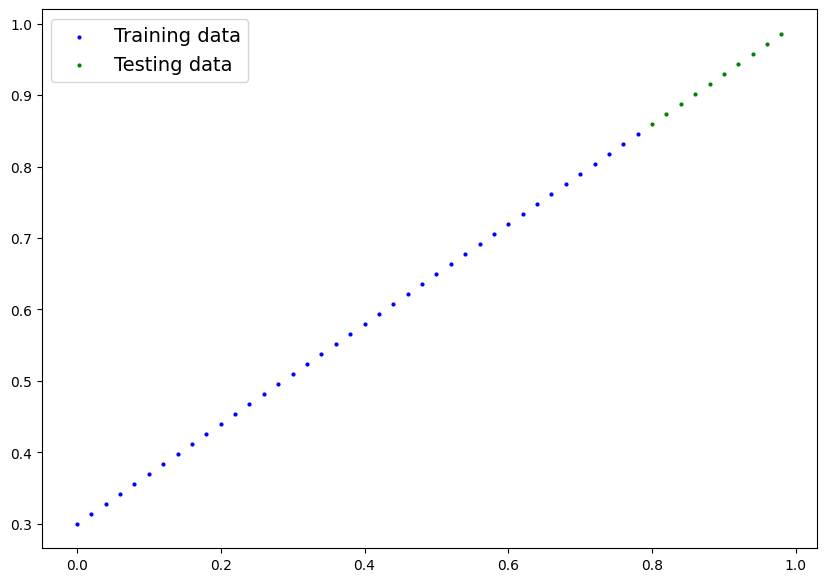

In [138]:
plot_predictions();

## <a id='toc1_3_'></a>[Build model](#toc0_)

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [139]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
    
    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True, # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float)) # <- PyTorch loves the datatype torch.float32 
    
  # Forward method to define the computation in the model
  # `x: torch.Tensor` 意思是 x 的型別必須要是 torch.Tensor
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### <a id='toc1_3_1_'></a>[PyTorch model building essentials](#toc0_)

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us 
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation 

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html 

### <a id='toc1_3_2_'></a>[Checking the contents of our PyTorch model](#toc0_)

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`.

In [140]:
# 如果要固定 torch.rand(1) 的值，前面都要加上 torch.manual_seed(42)
# torch.manual_seed(42)
torch.rand(1)

tensor([0.2666])

In [141]:
# Create a random seed
# 因為在model裡面有torch.rand
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [142]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [143]:
# 最一開始設定的weight跟bias
weight, bias

(0.7, 0.3)

### <a id='toc1_3_3_'></a>[Making prediction using `torch.inference_mode()`](#toc0_)

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [144]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [145]:
# Make predictions with model
# 推理模式API ( Inference Mode API ) 可以显著加速推理工作负载的速度，
# 同时保持安全，并确保永远不会计算不正确的梯度. 在不需要 autograd 时，其提供了最好的性能.
with torch.inference_mode():
  y_preds = model_0(X_test)
  

# # You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=cnKavO9iTgwQ-rfri6u7PQ 

In [146]:
# 因為weight跟bias不一樣，所以會跟y_preds不一樣
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

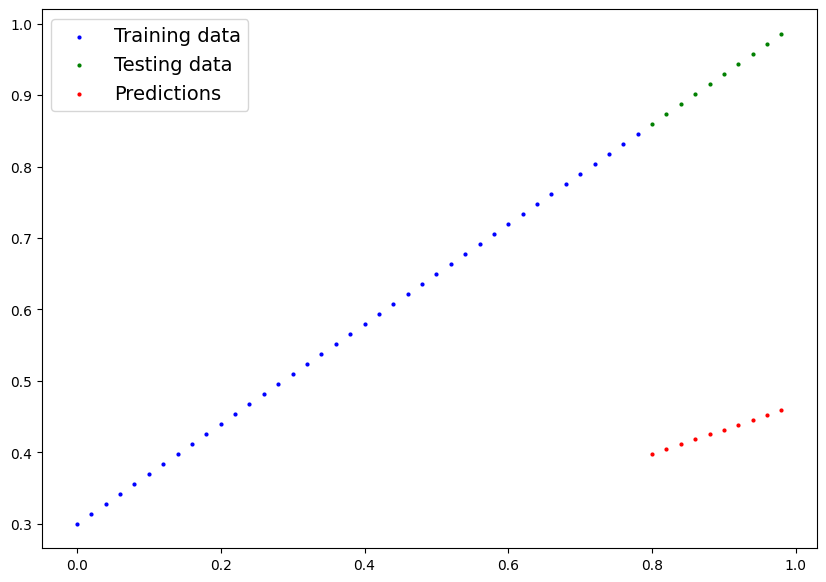

In [147]:
plot_predictions(predictions=y_preds)

## <a id='toc1_4_'></a>[Train model](#toc0_)

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better. - https://pytorch.org/docs/stable/nn.html#loss-functions
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [148]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [149]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [150]:
# =====================Setup a loss function for linear regression=====================
# use nn.L1Loss()
# nn.L1Loss() = torch.mean(torch.abs(y_pred-y_test))
loss_function = nn.L1Loss()

# use nn.MSELoss(), nn.MSELoss() = L2 Loss
# loss_fn = nn.MSELoss()

# =====================Setup an optimizer (stochastic gradient descent)=====================
# SGD Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            # lr = learning rate = possibly the most important hyperparameter you can set
                            # The larger the learning rate, the greater the magnitude of change in the weights and biases.
                            lr=0.001,    
                            momentum=0.9)

# Adam Optimizer
# optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

> **Q:** Which loss function and optimizer should I use?
>
> **A:** This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.
>
> For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.
>
> But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss). 

### <a id='toc1_4_1_'></a>[Building a training loop (and a testing loop) in PyTorch](#toc0_)

A couple of things we need in a training loop:

0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation 
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation** - https://www.youtube.com/watch?v=tIeHLnjs5U8)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent** - https://youtu.be/IHZwWFHWa-w)

In [151]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1

# ================Training================
# 0. Loop through the data
for epoch in range(epochs): 
    # Set the model to training mode
    model_0.train() # `train mode` in PyTorch sets all parameters that require gradients to require gradients 

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_function(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()  # reset

    # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
    print(model_0.state_dict())

OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])


In [152]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

# ================Training================
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_0.train() # `train mode` in PyTorch sets all parameters that require gradients to require gradients 
 
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_function(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()  # reset

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_function(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.3117292523384094 | Test loss: 0.4906295835971832
OrderedDict([('weights', tensor([0.3378])), ('bias', tensor([0.1317]))])
Epoch: 10 | Loss: 0.2573006749153137 | Test loss: 0.4198817312717438
OrderedDict([('weights', tensor([0.3583])), ('bias', tensor([0.1842]))])
Epoch: 20 | Loss: 0.1632838398218155 | Test loss: 0.30747395753860474
OrderedDict([('weights', tensor([0.3908])), ('bias', tensor([0.2677]))])
Epoch: 30 | Loss: 0.07037373632192612 | Test loss: 0.18448665738105774
OrderedDict([('weights', tensor([0.4274])), ('bias', tensor([0.3581]))])
Epoch: 40 | Loss: 0.049980729818344116 | Test loss: 0.09902867674827576
OrderedDict([('weights', tensor([0.4599])), ('bias', tensor([0.4147]))])
Epoch: 50 | Loss: 0.05151936411857605 | Test loss: 0.07666987180709839
OrderedDict([('weights', tensor([0.4780])), ('bias', tensor([0.4209]))])
Epoch: 60 | Loss: 0.04486861824989319 | Test loss: 0.090049609541893
OrderedDict([('weights', tensor([0.4866])), ('bias', tensor([0.3999]))])

In [153]:
# Check the training loss_valu and test_loss_values
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.31172925, 0.25730067, 0.16328384, 0.07037374, 0.04998073,
        0.05151936, 0.04486862, 0.04079776, 0.03762823, 0.03402161,
        0.03059093, 0.0271432 , 0.02370951, 0.02026755, 0.01683004,
        0.01339582, 0.00996141, 0.00652692, 0.00309346, 0.00095576],
       dtype=float32),
 [tensor(0.4906),
  tensor(0.4199),
  tensor(0.3075),
  tensor(0.1845),
  tensor(0.0990),
  tensor(0.0767),
  tensor(0.0900),
  tensor(0.0994),
  tensor(0.0935),
  tensor(0.0805),
  tensor(0.0692),
  tensor(0.0623),
  tensor(0.0552),
  tensor(0.0465),
  tensor(0.0386),
  tensor(0.0305),
  tensor(0.0225),
  tensor(0.0144),
  tensor(0.0064),
  tensor(0.0023)])

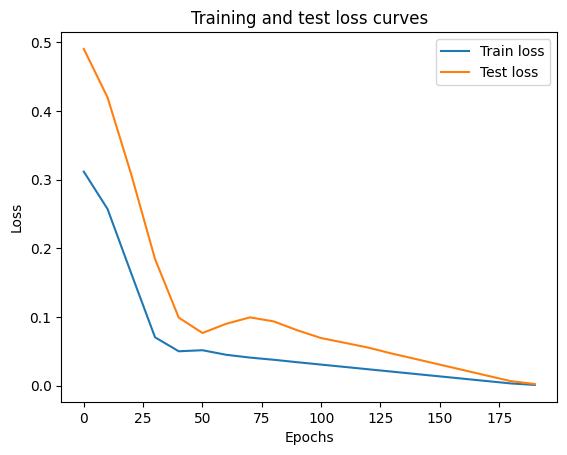

In [154]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")  # Train loss
plt.plot(epoch_count, test_loss_values, label="Test loss")  # Test loss
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [155]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [156]:
# Make pred value close to true value
model_0.state_dict()

OrderedDict([('weights', tensor([0.7055])), ('bias', tensor([0.2978]))])

In [157]:
# This is true value
weight, bias

(0.7, 0.3)

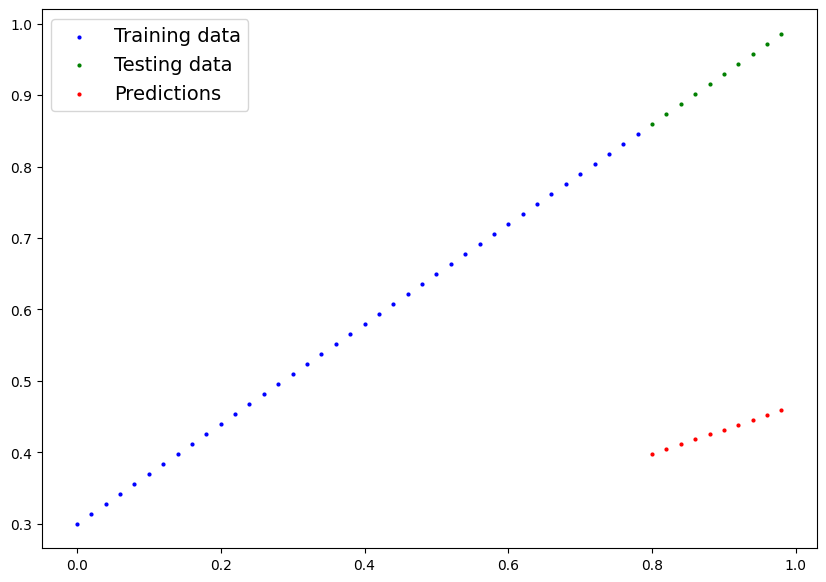

In [158]:
plot_predictions(predictions=y_preds);

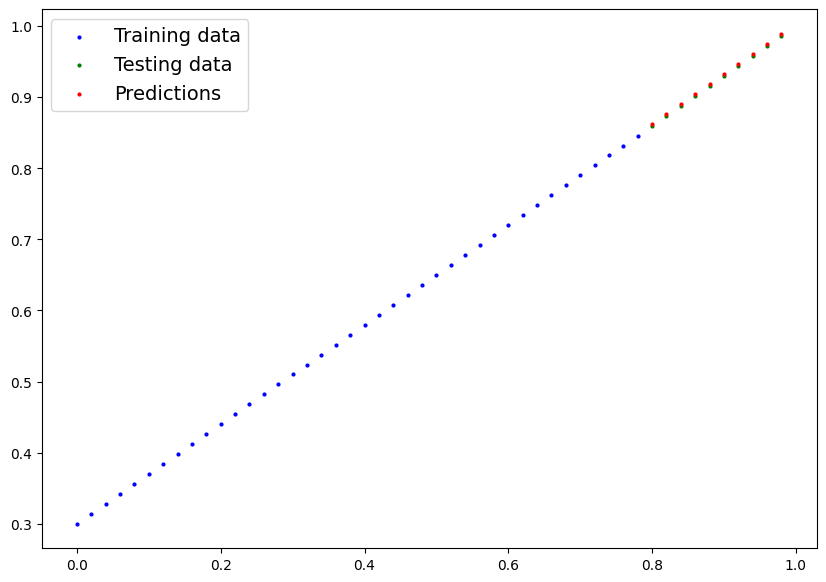

In [159]:
plot_predictions(predictions=y_preds_new);

## <a id='toc1_5_'></a>[Saving a model in PyTorch](#toc0_)

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format - https://docs.python.org/3/library/pickle.html
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary 

PyTorch save & load code tutorial + extra-curriculum - https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [201]:
# Saving our PyTorch model
from pathlib import Path

# =======1. Create models directory =======
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create subdirectories
state_dict_path = MODEL_PATH / "state_dict"
entire_model_path = MODEL_PATH / "entire_model"
state_dict_path.mkdir(parents=True, exist_ok=True)
entire_model_path.mkdir(parents=True, exist_ok=True)

# =======2. Create model save path=======
# A common PyTorch convention is to save models using either a .pt or .pth file extension
MODEL_NAME = "state_dict/01_pytorch_workflow_model_0_state_dict.pth"  # you also can use .pt file extension
MODEL_NAME_ENTIRE= "entire_model/01_pytorch_workflow_model_0.pth"  # # you also can use .pt file extension
MODEL_STATE_DICT_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_ENTIRE_SAVE_PATH = MODEL_PATH / MODEL_NAME_ENTIRE


# =======3. Save the model state dict=======
# Save state_dict()
print(f"Saving state_dict model to: {MODEL_STATE_DICT_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_STATE_DICT_SAVE_PATH)

# Save entire PyTorch model
print(f"Saving entire model to: {MODEL_ENTIRE_SAVE_PATH}")
torch.save(obj=model_0,
           f = MODEL_ENTIRE_SAVE_PATH)

Saving state_dict model to: models\state_dict\01_pytorch_workflow_model_0_state_dict.pth
Saving entire model to: models\entire_model\01_pytorch_workflow_model_0.pth


In [220]:
# =========Check our model if download success=========
for dirpath, dirnames, filenames in os.walk("models"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

for root, dirs, files in os.walk("models"):
    for f in files:
        print('{}'.format(f))

There are 2 directories and 0 images in 'models'.
There are 0 directories and 1 images in 'models\entire_model'.
There are 0 directories and 1 images in 'models\state_dict'.
01_pytorch_workflow_model_0.pth
01_pytorch_workflow_model_0_state_dict.pth


## <a id='toc1_6_'></a>[Loading a PyTorch model](#toc0_)

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that. 

In [203]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7055])), ('bias', tensor([0.2978]))])

In [204]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_STATE_DICT_SAVE_PATH))

<All keys matched successfully>

In [205]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.7055])), ('bias', tensor([0.2978]))])

In [206]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8622],
        [0.8763],
        [0.8904],
        [0.9045],
        [0.9186],
        [0.9328],
        [0.9469],
        [0.9610],
        [0.9751],
        [0.9892]])

In [207]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8622],
        [0.8763],
        [0.8904],
        [0.9045],
        [0.9186],
        [0.9328],
        [0.9469],
        [0.9610],
        [0.9751],
        [0.9892]])

In [208]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [209]:
# Load entire model
loaded_model_0 = torch.load(MODEL_ENTIRE_SAVE_PATH)
loaded_model_0

LinearRegressionModel()

In [210]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8622],
        [0.8763],
        [0.8904],
        [0.9045],
        [0.9186],
        [0.9328],
        [0.9469],
        [0.9610],
        [0.9751],
        [0.9892]])

In [211]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## <a id='toc1_7_'></a>[Putting it all together](#toc0_)

Let's go back through the steps above and see it all in one place.

In [81]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [82]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### <a id='toc1_7_1_'></a>[Data](#toc0_)

In [83]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [86]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [87]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop={"size": 14});

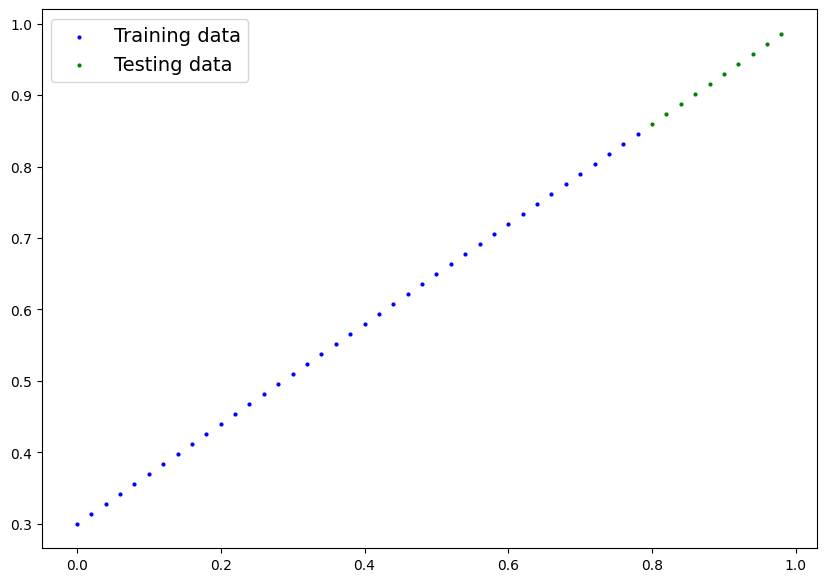

In [88]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### <a id='toc1_7_2_'></a>[Building a PyTorch Linear model](#toc0_)

In [ ]:
class LinearRegressionModelV2(nn.module):
    def __init__(self):
        super().__init__()
        

In [90]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [91]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [92]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [93]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [94]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [95]:
model_1.state_dict() 

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### <a id='toc1_7_3_'></a>[Training](#toc0_)

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data) 
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0: 
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
weight, bias 

(0.7, 0.3)

### <a id='toc1_7_4_'></a>[Making and evaluating predictions](#toc0_)

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

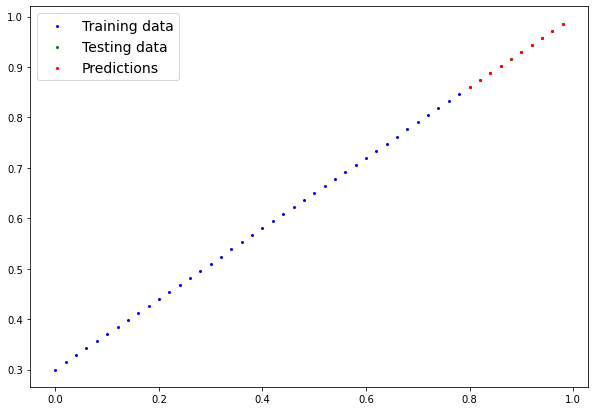

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### <a id='toc1_7_5_'></a>[Saving & loading a trained model](#toc0_)

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Load a PyTorch model

# Create a new instance of lienar regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## <a id='toc1_8_'></a>[Exercises & Extra-curriculum](#toc0_)

For exercise & extra-curriculum, refer to: https://www.learnpytorch.io/01_pytorch_workflow/#exercises 